Using device: cuda
GPU: NVIDIA GeForce RTX 3060

Checking dataset paths:
Train images: True - F:\skills-copilot-codespaces-vscode\thesis\rsuddataset\rsud20k\images\train
Train labels: True - F:\skills-copilot-codespaces-vscode\thesis\rsuddataset\rsud20k\labels\train
Val images: True - F:\skills-copilot-codespaces-vscode\thesis\rsuddataset\rsud20k\images\val
Val labels: True - F:\skills-copilot-codespaces-vscode\thesis\rsuddataset\rsud20k\labels\val

Creating training dataset...
Loading dataset from 18681 label files...
✓ Loaded 118810 object samples from 18681 images
✓ Loaded 118810 object samples from 18681 images

Class distribution:
  0: person               -  32884 samples
  1: rickshaw             -  22694 samples
  2: rickshaw_van         -   2727 samples
  3: auto_rickshaw        -  12509 samples
  4: truck                -   1506 samples
  5: pickup_truck         -   1035 samples
  6: private_car          -  18117 samples
  7: motorcycle           -  14801 samples
  8: bicycle

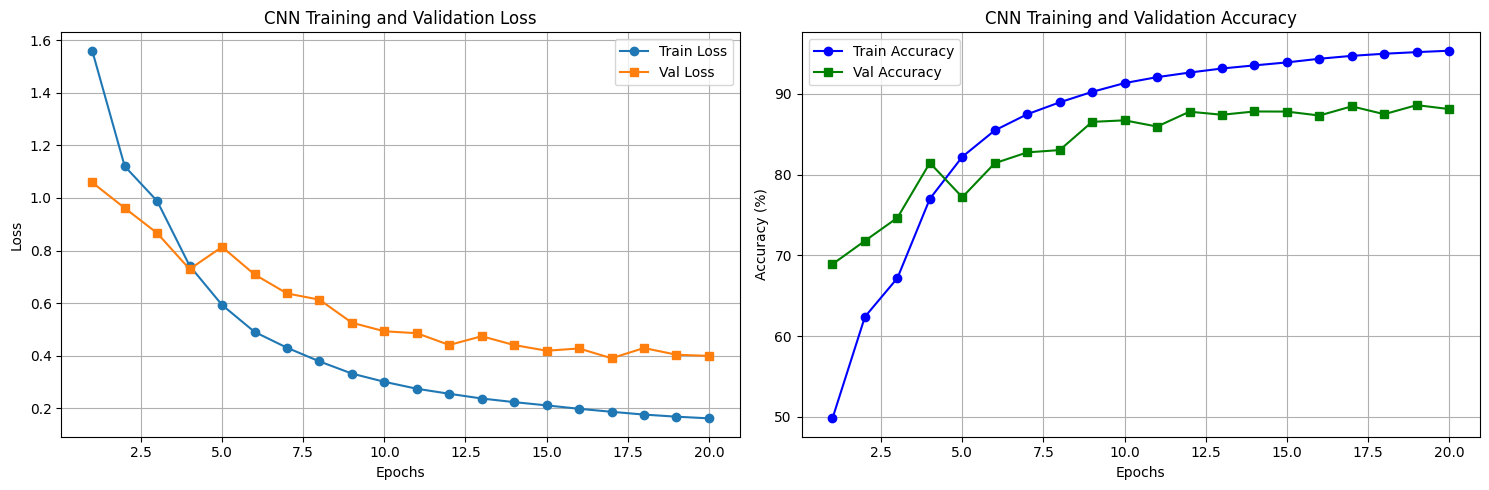


✓ CNN training complete! Run model_evu.ipynb to evaluate.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
from pathlib import Path
import numpy as np

# GPU check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# ------------------------
# Custom YOLO Dataset for Classification
# ------------------------
class YOLOClassificationDataset(Dataset):
    """
    Custom dataset that reads YOLO format labels and crops individual objects
    for classification training.
    """
    def __init__(self, images_dir, labels_dir, transform=None, min_bbox_size=20):
        self.images_dir = Path(images_dir)
        self.labels_dir = Path(labels_dir)
        self.transform = transform
        self.min_bbox_size = min_bbox_size
        
        # Load class names
        data_yaml = Path(r"F:\skills-copilot-codespaces-vscode\thesis\rsuddataset\rsud20k\images\data.yaml")
        self.class_names = [
            'person', 'rickshaw', 'rickshaw_van', 'auto_rickshaw', 'truck',
            'pickup_truck', 'private_car', 'motorcycle', 'bicycle', 'bus',
            'micro_bus', 'covered_van', 'human_hauler'
        ]
        
        # Build dataset: list of (image_path, label_path, bbox_idx)
        self.samples = []
        label_files = sorted(self.labels_dir.glob("*.txt"))
        
        print(f"Loading dataset from {len(label_files)} label files...")
        for label_file in label_files:
            img_name = label_file.stem + ".jpg"
            img_path = self.images_dir / img_name
            
            if not img_path.exists():
                continue
            
            # Read all bboxes from this label file
            with open(label_file, 'r') as f:
                lines = f.readlines()
            
            for idx, line in enumerate(lines):
                parts = line.strip().split()
                if len(parts) >= 5:
                    self.samples.append((img_path, label_file, idx))
        
        print(f"✓ Loaded {len(self.samples)} object samples from {len(label_files)} images")
        
        # Count samples per class
        class_counts = [0] * len(self.class_names)
        for img_path, label_path, bbox_idx in self.samples:
            with open(label_path, 'r') as f:
                lines = f.readlines()
            class_id = int(lines[bbox_idx].strip().split()[0])
            class_counts[class_id] += 1
        
        print("\nClass distribution:")
        for i, (name, count) in enumerate(zip(self.class_names, class_counts)):
            print(f"  {i}: {name:20s} - {count:6d} samples")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label_path, bbox_idx = self.samples[idx]
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        img_w, img_h = image.size
        
        # Read bbox from label file
        with open(label_path, 'r') as f:
            lines = f.readlines()
        
        parts = lines[bbox_idx].strip().split()
        class_id = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:5])
        
        # Convert YOLO format (normalized) to pixel coordinates
        x_center_px = x_center * img_w
        y_center_px = y_center * img_h
        width_px = width * img_w
        height_px = height * img_h
        
        x1 = int(x_center_px - width_px / 2)
        y1 = int(y_center_px - height_px / 2)
        x2 = int(x_center_px + width_px / 2)
        y2 = int(y_center_px + height_px / 2)
        
        # Clamp to image boundaries
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(img_w, x2)
        y2 = min(img_h, y2)
        
        # Crop object
        cropped = image.crop((x1, y1, x2, y2))
        
        # Apply transforms
        if self.transform:
            cropped = self.transform(cropped)
        
        return cropped, class_id

# ------------------------
# Dataset Setup - YOLO Format
# ------------------------
data_root = Path(r"F:\skills-copilot-codespaces-vscode\thesis\rsuddataset\rsud20k")
train_images_dir = data_root / "images" / "train"
train_labels_dir = data_root / "labels" / "train"
val_images_dir = data_root / "images" / "val"
val_labels_dir = data_root / "labels" / "val"

print(f"\nChecking dataset paths:")
print(f"Train images: {train_images_dir.exists()} - {train_images_dir}")
print(f"Train labels: {train_labels_dir.exists()} - {train_labels_dir}")
print(f"Val images: {val_images_dir.exists()} - {val_images_dir}")
print(f"Val labels: {val_labels_dir.exists()} - {val_labels_dir}")

batch_size = 32
img_size = 224

# Transforms with data augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print("\n" + "="*60)
print("Creating training dataset...")
print("="*60)
train_dataset = YOLOClassificationDataset(
    train_images_dir, train_labels_dir, 
    transform=train_transform, min_bbox_size=20
)

print("\n" + "="*60)
print("Creating validation dataset...")
print("="*60)
val_dataset = YOLOClassificationDataset(
    val_images_dir, val_labels_dir, 
    transform=val_transform, min_bbox_size=20
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

num_classes = 13  # RSUD20K has 13 classes
print(f"\n✓ Dataset ready:")
print(f"  Classes: {num_classes}")
print(f"  Train samples: {len(train_dataset)}")
print(f"  Val samples: {len(val_dataset)}")

# ------------------------
# CNN Model Definition
# ------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        # Calculate flattened size after convolutions
        # img_size=224 -> after 4 maxpools (224/16=14)
        flattened_size = 512 * (img_size // 16) ** 2
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN(num_classes).to(device)
print(f"\n✓ Model created with {sum(p.numel() for p in model.parameters()):,} parameters")

# ------------------------
# Loss & Optimizer
# ------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# ------------------------
# Output directory
# ------------------------
output_dir = Path(r"F:\skills-copilot-codespaces-vscode\thesis\checkpoints")
output_dir.mkdir(parents=True, exist_ok=True)

# ------------------------
# Training Loop
# ------------------------
num_epochs = 20
train_losses, val_losses, val_accs, train_accs = [], [], [], []
best_val_acc = 0.0

print(f"\n" + "="*60)
print(f"Starting CNN training for {num_epochs} epochs...")
print("="*60)

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        if (batch_idx + 1) % 100 == 0:
            print(f"  Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print("="*60)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), output_dir / "cnn_best.pth")
        print(f"  ✓ Saved best model (Val Acc: {val_acc:.2f}%)")

# ------------------------
# Save final model
# ------------------------
torch.save(model.state_dict(), output_dir / "cnn_final.pth")
print(f"\n✓ CNN training completed!")
print(f"  Best validation accuracy: {best_val_acc:.2f}%")
print(f"  Models saved to: {output_dir.absolute()}")

# ------------------------
# Plot training curves
# ------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
ax1.plot(range(1, num_epochs+1), val_losses, label="Val Loss", marker='s')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("CNN Training and Validation Loss")
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(range(1, num_epochs+1), train_accs, label="Train Accuracy", marker='o', color='blue')
ax2.plot(range(1, num_epochs+1), val_accs, label="Val Accuracy", marker='s', color='green')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy (%)")
ax2.set_title("CNN Training and Validation Accuracy")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig(output_dir / "cnn_training_curves.png", dpi=150)
print(f"  Training curves saved to: {output_dir / 'cnn_training_curves.png'}")
plt.show()

print("\n" + "="*60)
print("✓ CNN training complete! Run model_evu.ipynb to evaluate.")
print("="*60)